# Heisenberg model with MPS DMRG

## Off the shelf

In [1]:
using ITensors
using PyPlot
using Statistics

In [2]:
function HXXZ_dmrg_ready(N, Jxx, Jz)
    
  sites = siteinds("S=1/2",N)

  ampo = OpSum()
  for j=1:N-1
    ampo += Jxx*0.5,"S+",j,"S-",j+1
    ampo += Jxx*0.5,"S-",j,"S+",j+1
    ampo += Jz,"Sz",j,"Sz",j+1
  end
  H = MPO(ampo,sites)

  sweeps = Sweeps(5) # number of sweeps is 5
  maxdim!(sweeps,10,20,100,100,200) # gradually increase states kept
  cutoff!(sweeps,1E-10) # desired truncation error

  psi0 = randomMPS(sites,2)

  energy,psi = dmrg(H,psi0,sweeps)

  return energy, psi
end

HXXZ_dmrg_ready (generic function with 1 method)

In [4]:
e, p = HXXZ_dmrg_ready(10000,2.5,3.6)
e/10000

After sweep 1 energy=-12726.477527537078  maxlinkdim=8 maxerr=5.90E-16 time=10.454
After sweep 2 energy=-12813.472642310157  maxlinkdim=20 maxerr=9.63E-07 time=28.728
After sweep 3 energy=-12821.052897499509  maxlinkdim=72 maxerr=1.00E-10 time=189.928
After sweep 4 energy=-12822.978085552733  maxlinkdim=84 maxerr=1.00E-10 time=370.027


LoadError: InterruptException:

In [ ]:
trial[]

for n in [a^2 for a in 5:20:100]
    E, psi = HXXZ_dmrg_ready(n,0.2,0.5)
    push!(trial, E/n)
end

In [ ]:
trial

In [138]:
N = 100
Jxx = [-3.5,-2.0,-0.7,0.1,0.7,2.,3.5]
Deltas = [-3.0,-1.5,-0.8,0.1,0.8,1.5,3.0]

e = []
gr_st = []

for delta in Deltas
    for j in Jxx
        E, psi = HXXZ_dmrg_ready(N,j,delta*j)
        push!(e, E/N)
        push!(gr_st, psi)
    end
end


After sweep 1 energy=-285.95468095743445  maxlinkdim=8 maxerr=3.82E-16 time=0.153
After sweep 2 energy=-286.2472070970444  maxlinkdim=20 maxerr=8.56E-10 time=0.256
After sweep 3 energy=-288.49889693808666  maxlinkdim=30 maxerr=9.99E-11 time=0.370
After sweep 4 energy=-288.4990612988864  maxlinkdim=18 maxerr=1.00E-10 time=0.286
After sweep 5 energy=-288.4990613071373  maxlinkdim=17 maxerr=9.46E-11 time=0.251
After sweep 1 energy=-164.7733186085964  maxlinkdim=8 maxerr=3.64E-16 time=0.139
After sweep 2 energy=-164.85660175436453  maxlinkdim=18 maxerr=9.95E-11 time=0.215
After sweep 3 energy=-164.85660646053515  maxlinkdim=18 maxerr=9.99E-11 time=0.275
After sweep 4 energy=-164.85660646115525  maxlinkdim=17 maxerr=9.10E-11 time=0.252
After sweep 5 energy=-164.85660646104145  maxlinkdim=17 maxerr=8.97E-11 time=0.290
After sweep 1 energy=-57.19380490690199  maxlinkdim=8 maxerr=4.59E-16 time=0.125
After sweep 2 energy=-57.24483016910676  maxlinkdim=20 maxerr=7.92E-10 time=0.262
After sweep 3

After sweep 2 energy=-88.57060877906845  maxlinkdim=20 maxerr=1.11E-07 time=0.291
After sweep 3 energy=-88.73115962424909  maxlinkdim=44 maxerr=9.99E-11 time=1.001
After sweep 4 energy=-88.79475368860597  maxlinkdim=46 maxerr=1.00E-10 time=1.383
After sweep 5 energy=-88.83777685026205  maxlinkdim=45 maxerr=9.99E-11 time=1.413
After sweep 1 energy=-106.06570425065216  maxlinkdim=8 maxerr=1.36E-15 time=0.109
After sweep 2 energy=-107.19424082780787  maxlinkdim=20 maxerr=2.45E-07 time=0.285
After sweep 3 energy=-107.27893548489301  maxlinkdim=52 maxerr=9.99E-11 time=1.195
After sweep 4 energy=-107.29800875972681  maxlinkdim=62 maxerr=9.95E-11 time=1.989
After sweep 5 energy=-107.30501897499437  maxlinkdim=87 maxerr=9.99E-11 time=2.398
After sweep 1 energy=-60.66021360804826  maxlinkdim=8 maxerr=3.74E-16 time=0.110
After sweep 2 energy=-61.26838906716312  maxlinkdim=20 maxerr=2.08E-07 time=0.285
After sweep 3 energy=-61.30558624593274  maxlinkdim=50 maxerr=9.99E-11 time=1.177
After sweep 4

After sweep 2 energy=-103.9623196418666  maxlinkdim=20 maxerr=2.65E-07 time=0.323
After sweep 3 energy=-104.09721380280293  maxlinkdim=58 maxerr=9.99E-11 time=1.616
After sweep 4 energy=-104.13600006280008  maxlinkdim=79 maxerr=1.00E-10 time=2.747
After sweep 5 energy=-104.14914003853227  maxlinkdim=99 maxerr=1.00E-10 time=2.675
After sweep 1 energy=-180.00260273206888  maxlinkdim=8 maxerr=4.04E-16 time=0.109
After sweep 2 energy=-182.07269707435586  maxlinkdim=20 maxerr=7.24E-07 time=0.340
After sweep 3 energy=-182.24074133589207  maxlinkdim=57 maxerr=9.98E-11 time=1.384
After sweep 4 energy=-182.27314223247484  maxlinkdim=82 maxerr=9.99E-11 time=2.544
After sweep 5 energy=-182.27844096476932  maxlinkdim=85 maxerr=9.99E-11 time=3.196
After sweep 1 energy=-259.862750935515  maxlinkdim=8 maxerr=9.55E-11 time=0.108
After sweep 2 energy=-259.8749999317534  maxlinkdim=5 maxerr=9.98E-11 time=0.107
After sweep 3 energy=-259.8750000000003  maxlinkdim=1 maxerr=1.16E-12 time=0.092
After sweep 4

In [139]:
matrix = Matrix{Float64}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        matrix[i,j] = e[(i-1)*length(Jxx)+j]
    end
end

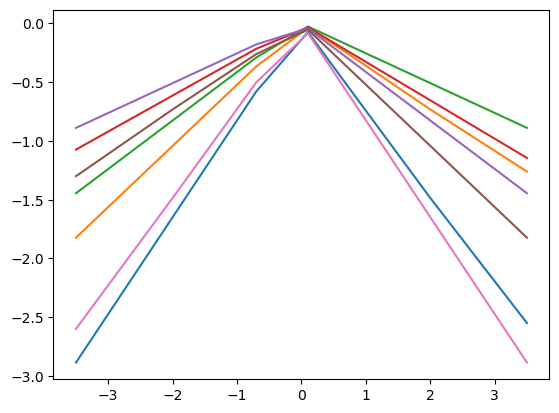

In [140]:
for j=1:length(Deltas)
    plot(Jxx, matrix[j,:]);
end

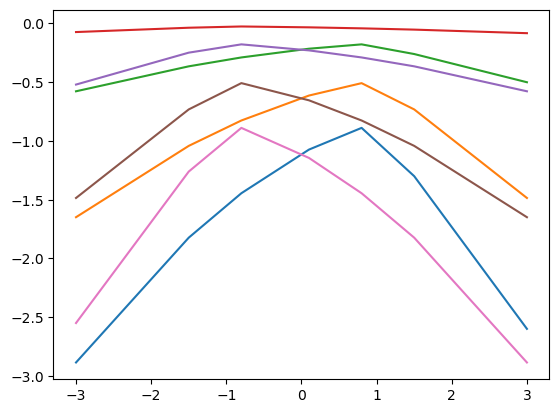

In [141]:
for j=1:length(Jxx)
    plot(Deltas, matrix[:,j]);
end

In [142]:
states = Matrix{MPS}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        states[i,j] = gr_st[(i-1)*length(Jxx)+j]
    end
end

In [143]:
sz_m = Matrix{Vector{Float64}}(undef, length(Deltas), length(Jxx))
sx_m = Matrix{Vector{Float64}}(undef, length(Deltas), length(Jxx))
avg_sz = Matrix{Float64}(undef, length(Deltas), length(Jxx))
avg_sx = Matrix{Float64}(undef, length(Deltas), length(Jxx))

for i=1:length(Deltas)
    for j=1:length(Jxx)
        sz_m[i,j] = expect(states[i,j], "Sz")
        sx_m[i,j] = expect(states[i,j], "Sx")
        avg_sz[i,j] = mean(sz_m[i,j])
        avg_sx[i,j] = mean(sx_m[i,j])
    end
end


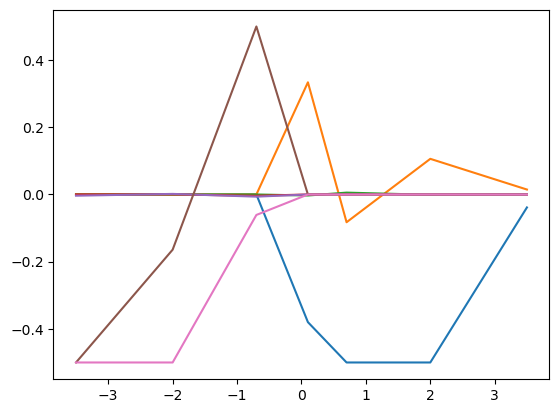

In [144]:
for j=1:length(Deltas)
    plot(Jxx, avg_sz[j,:]);
end

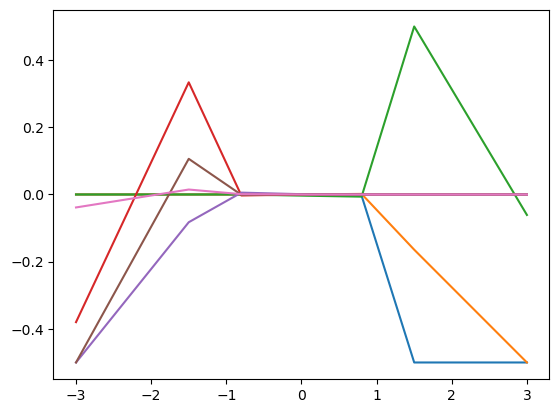

In [145]:
for j=1:length(Jxx)
    plot(Deltas, avg_sz[:,j]);
end

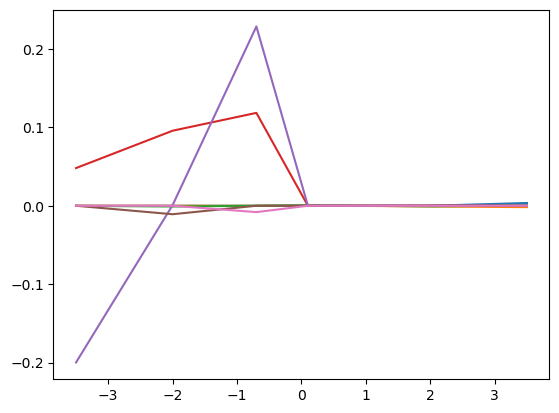

In [146]:
for j=1:length(Deltas)
    plot(Jxx, avg_sx[j,:]);
end

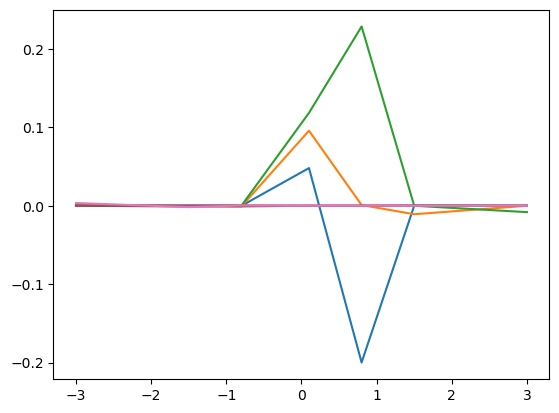

In [147]:
for j=1:length(Jxx)
    plot(Deltas, avg_sx[:,j]);
end

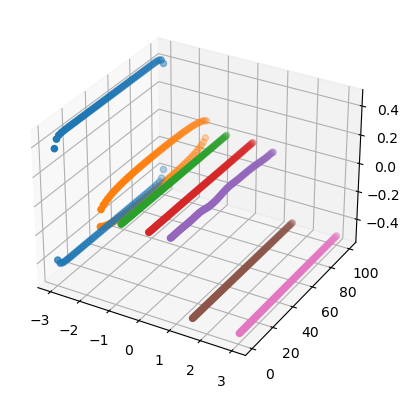

In [148]:
for i=1:length(Deltas)
    scatter3D([Deltas[i] for j=1:N], 1:N, sz_m[i,1])
end

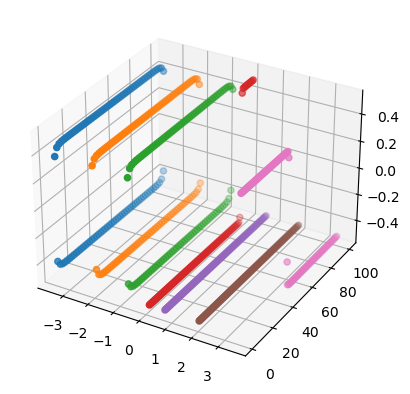

In [153]:
for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:N], 1:N, sz_m[1,i]);
end

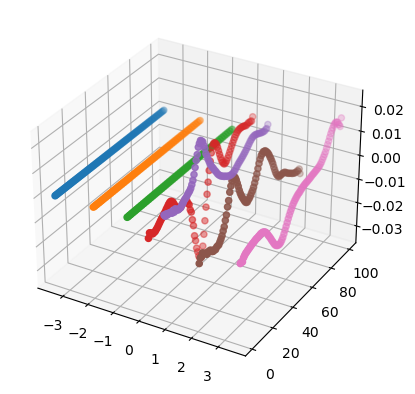

In [154]:
for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:N], 1:N, sz_m[3,i]);
end

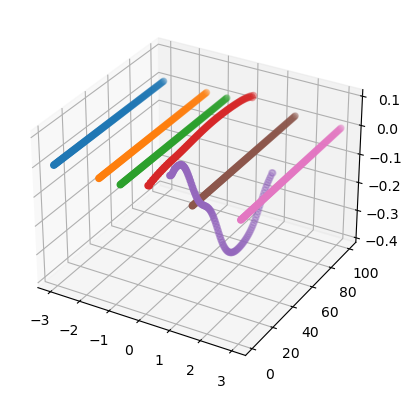

In [158]:
for i=1:length(Deltas)
    scatter3D([Deltas[i] for j=1:N], 1:N, sx_m[i,1])
end

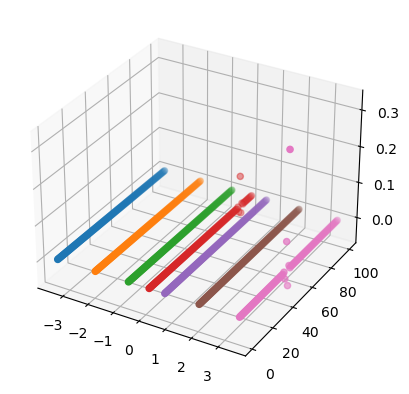

In [159]:
for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:N], 1:N, sx_m[1,i]);
end

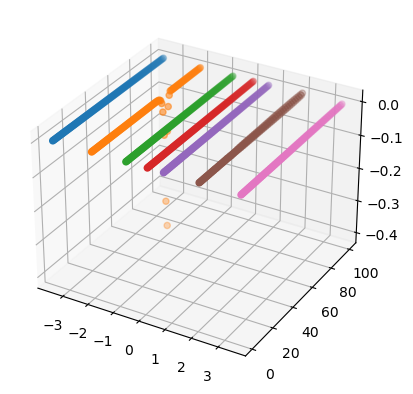

In [160]:
for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:N], 1:N, sx_m[6,i]);
end

In [161]:
zz_cor = Matrix{Any}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        zz_cor[i,j] = correlation_matrix(states[i,j],"Sz","Sz")
    end
end

In [162]:
avg_cor = Matrix{Float64}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        sum = 0
        for k=1:N
            for l=k+1:N
                sum += zz_cor[i,j][k,l]
            end
        end
        sum = sum/(N^2/2-N/2)
        avg_cor[i,j] = sum
    end
end

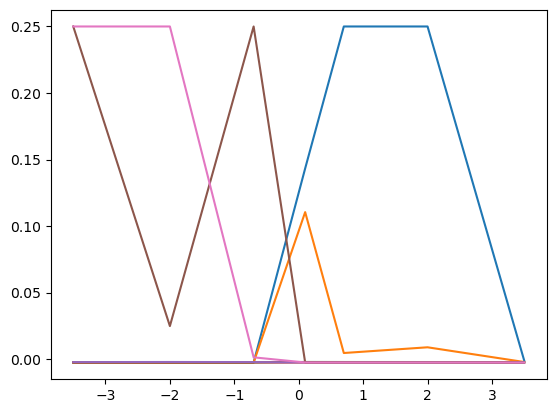

In [163]:
for j=1:length(Deltas)
    plot(Jxx, avg_cor[j,:]);
end

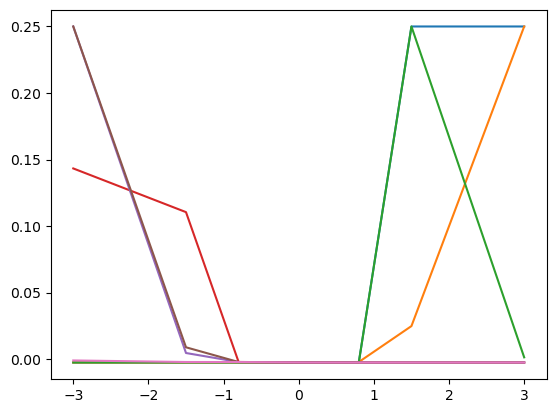

In [164]:
for j=1:length(Jxx)
    plot(Deltas, avg_cor[:,j]);
end

In [165]:
cor_dist = Matrix{Any}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        dist = []
        corr = []
        for k=1:N
            for l=k+1:N
                push!(dist, abs(k-l))
                push!(corr, zz_cor[i,j][k,l])
            end
        end
        cor_dist[i,j] = [dist, corr]
    end
end

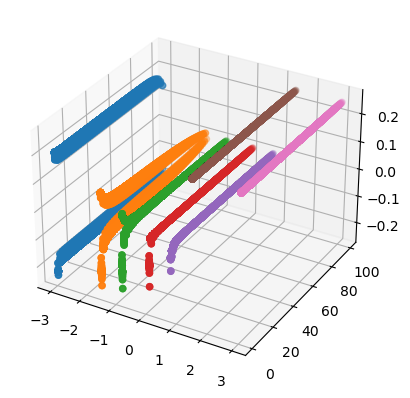

In [166]:
len = length(cor_dist[1,1][1])

for i=1:length(Deltas)
    scatter3D([Deltas[i] for j=1:len], cor_dist[i,1][1], cor_dist[i,1][2])
end

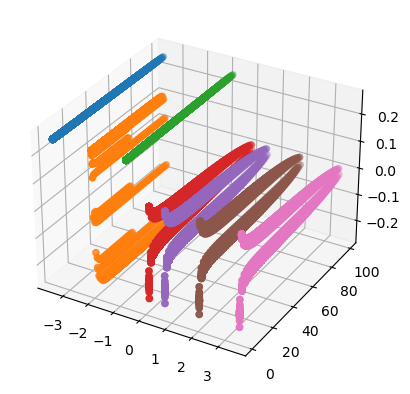

In [167]:
len = length(cor_dist[1,1][1])

for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:len], cor_dist[6,i][1], cor_dist[6,i][2])
end

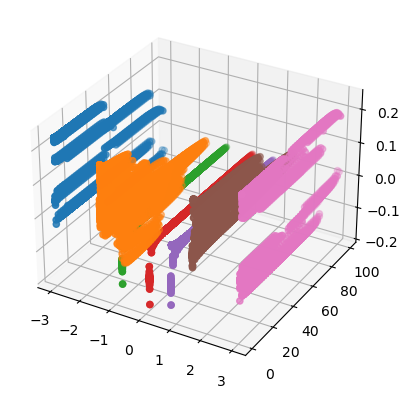

In [168]:
len = length(cor_dist[1,1][1])

mean_j = []
for i=1:length(Deltas)
    dist = [0 for k=1:len]
    corr = [0 for k=1:len]
    for j=1:length(Jxx)
        dist += cor_dist[i,j][1]
        corr += cor_dist[i,j][2]
    end
    push!(mean_j, [dist/length(Jxx), corr/length(Jxx)])
end

for i=1:length(Deltas)
    scatter3D([Deltas[i] for j=1:len], mean_j[i][1], mean_j[i][2])
end

## Self-made

In [1]:
using ITensors
using PyPlot

In [2]:
function gauge(psi, N, bonds, bond)
    up = prod(psi)
    n = up*up
    n = n[1]
    
    up = up/sqrt(n)
    block = ITensor()
    for i=1:N-1
        ind = unioninds(up)[i]
        if i == 1
            block = up
            U,S,V = svd(block, ind; maxdim=bond)
            psi[i] = U
            bonds[i] = commoninds(U,S)[1]
            block = S*V
        elseif i == N-1
            U,S,V = svd(block, ind, bonds[i-1]; maxdim=bond)
            psi[i] = U
            bonds[i] = commoninds(U,S)[1]
            psi[i+1] = S*V
        else
            U,S,V = svd(block, ind, bonds[i-1]; maxdim=bond)
            psi[i] = U
            bonds[i] = commoninds(U,S)[1]
            block = S*V
        end
    end
    
    return psi, bonds
end

gauge (generic function with 1 method)

In [35]:
function HXXZ_idmrg(N, Jxx, Jz, sweeps=3, bond=4, max_err=1e-4)
    
    # N must be even
    if iseven(N) == false
        N -= 1
    end
    if N > 10
        print("error: unit cell size N must be <= 10")
    end
    if max_err >= 1
        print("error: max_err must be < 1")
    end
    
    o_ind = [Index(2) for i=1:N]
    bonds = [Index(bond) for i=1:N-1]
    
    Sz = ITensor[]
    Sp = ITensor[]
    Sm = ITensor[]
    Id = ITensor[]
    psi = ITensor[]
    psi_bar = ITensor[]
    for i=1:N
        push!(Sz, ITensor(o_ind[i], o_ind[i]'))
        Sz[i][o_ind[i]=>1, o_ind[i]'=>1] = 0.5
        Sz[i][o_ind[i]=>1, o_ind[i]'=>2] = 0
        Sz[i][o_ind[i]=>2, o_ind[i]'=>1] = 0
        Sz[i][o_ind[i]=>2, o_ind[i]'=>2] = -0.5
        
        push!(Sp, ITensor(o_ind[i], o_ind[i]'))
        Sp[i][o_ind[i]'=>1, o_ind[i]=>1] = 0
        Sp[i][o_ind[i]'=>1, o_ind[i]=>2] = 1
        Sp[i][o_ind[i]'=>2, o_ind[i]=>1] = 0
        Sp[i][o_ind[i]'=>2, o_ind[i]=>2] = 0
        
        push!(Sm, ITensor(o_ind[i], o_ind[i]'))
        Sm[i][o_ind[i]'=>1, o_ind[i]=>1] = 0
        Sm[i][o_ind[i]'=>1, o_ind[i]=>2] = 0
        Sm[i][o_ind[i]'=>2, o_ind[i]=>1] = 1
        Sm[i][o_ind[i]'=>2, o_ind[i]=>2] = 0
        
        push!(Id, ITensor(o_ind[i], o_ind[i]'))
        Id[i][o_ind[i]=>1, o_ind[i]'=>1] = 1
        Id[i][o_ind[i]=>1, o_ind[i]'=>2] = 0
        Id[i][o_ind[i]=>2, o_ind[i]'=>1] = 0
        Id[i][o_ind[i]=>2, o_ind[i]'=>2] = 1
        
        if i == 1
            push!(psi, randomITensor(o_ind[i], bonds[i]))
        elseif i == N
            push!(psi, randomITensor(o_ind[i], bonds[i-1]))
        else
            push!(psi, randomITensor(o_ind[i], bonds[i-1], bonds[i]))
        end
    end
    
    psi, bonds = gauge(psi, N, bonds, bond)
    for i=1:N
        push!(psi_bar, psi[i]')
    end
    
    H = ITensor()
    
    for i=1:N-1
        temp = 0.5 * Jxx*(Sp[i]*Sm[i+1]+Sm[i]*Sp[i+1]) + Jz*Sz[i]Sz[i+1]
        for j=1:i-1
            temp = temp * Id[j]
        end
        for j=i+2:N
            temp = temp * Id[j]
        end
        H += temp
    end
    
    
    """
    GROWING H WITH iDMRG
    """
    h = Integer(N/2)
    crop = h-1
    
    H_l = ITensor()
    H_r = ITensor()
    for i=1:h-1
        temp = 0.5 * Jxx*(Sp[i]*Sm[i+1]+Sm[i]*Sp[i+1]) + Jz*Sz[i]Sz[i+1]
        for j=1:i-1
            temp = temp * Id[j]
        end
        for j=i+2:h
            temp = temp * Id[j]
        end
        H_l += temp
    end
    for i=h+1:N-1
        temp = 0.5 * Jxx*(Sp[i]*Sm[i+1]+Sm[i]*Sp[i+1]) + Jz*Sz[i]Sz[i+1]
        for j=h+1:i-1
            temp = temp * Id[j]
        end
        for j=i+2:N
            temp = temp * Id[j]
        end
        H_r += temp 
    end
    
    h_id = Id[1]
    for i=2:crop
        h_id = h_id*Id[i]
    end
    if N > 4
        id_sub = Id[1]
    else
        id_sub = 1
    end
    for i=2:h-2
        id_sub = int_sub*Id[i]
    end
    int_sub_l = id_sub * (0.5 * Jxx*(Sp[h-1]*Sm[h]+Sm[h-1]*Sp[h]) + Jz*Sz[h-1]Sz[h])
    int_sub_r = id_sub * (0.5 * Jxx*(Sp[h+1]*Sm[h-1]+Sm[h+1]*Sp[h-1]) + Jz*Sz[h+1]Sz[h-1])
    #interaction between h-1 and h+1, given that the h-1 indices get contracted
    D,U = eigen(h_id; ishermitian=true)
    int_l = U'*int_sub_l*U
    int_r = U'*int_sub_r*U
    
    prev = 1.
    energy = 1.
    err = 1.
    first = 0
    eff_dim = N
    while max_err < err
        D,U = eigen(H; ishermitian=true, maxdim=1)
        energy = D[1,1]
        ind = uniqueinds(U,D)
        Uc = replaceinds(U, ind, ind')
        rho = U*Uc
        if first == 0
            ir = o_ind[h+1:N]
            il = o_ind[1:h]
        else
            ir = unique(noprime(unioninds(H_r)))
            il = unique(noprime(unioninds(H_l)))
        end
        rho_l = rho * delta(ir[1],ir[1]')
        for i in ir[2:length(ir)]
            rho_l = rho_l * delta(i,i')
        end
        
        D,Ul = eigen(rho_l; ishermitian=true, maxdim=2^crop, mindim=2^crop)
        #mono = dim(unioninds(D)[1])
        inds = unioninds(D)
        H_l = Ul'*H_l*Ul
        Ur = replaceinds(Ul, il, ir)
        replaceinds!(Ur, il', ir')
        H_r = Ur'*H_r*Ur
        i_t = Index(2^crop)
        newr = [i_t', i_t]
        replaceinds!(H_r, inds, newr)
        
        replaceinds!(int_l, uniqueinds(int_l,Sz[h]), inds)
        replaceinds!(int_r, uniqueinds(int_r,Sz[h+1]), newr)
        
        H = (H_l*replaceinds(replaceinds(Ur',ir',ir)*Ur, inds, newr)*Id[h]*Id[h+1] + 
            replaceinds(Ul',il',il)*Ul*replaceinds(H_r, inds, newr)*Id[h]*Id[h+1] +
            int_l*replaceinds(replaceinds(Ur',ir',ir)*Ur, inds, newr)*Id[h+1] +
            int_r*replaceinds(Ul',il',il)*Ul*Id[h] +
            replaceinds(Ul',il',il)*Ul*replaceinds(replaceinds(Ur',ir',ir)*Ur, inds, newr)*
            (0.5 * Jxx*(Sp[h]*Sm[h+1]+Sm[h]*Sp[h+1]) + Jz*Sz[h]Sz[h+1]))
        H_l = H_l*Id[h] + int_l
        H_r = H_r*Id[h+1] + int_r
    
        if first == 0
            first += 1
            prev = energy
        else
            err = abs((prev-energy)/prev)
            prev = energy
        end
        #print("energy: ",energy,"\tchange: ",err,"\n")
        eff_dim += 2
    end
    
    print("energy/N: ",energy/eff_dim,"\tchange: ",err,"effective dimension: ",eff_dim,"\n")
    
    
    ### reshaping H
    inds = unique(noprime(unioninds(H)))
    transf = delta(inds[1],inds[1]')
    for i=2:length(inds)
        transf = transf * delta(inds[i],inds[i]')
    end
    D,U = eigen(transf; ishermitian=true)
    Hsq = U'*H*U
    ind = noprime(unioninds(Hsq)[1])
    transf = delta(o_ind[1],o_ind[1]')
    for i=2:length(o_ind)
        transf = transf * delta(o_ind[i],o_ind[i]')
    end
    D,U = eigen(transf; ishermitian=true)
    replaceinds!(U, noprime(uniqueinds(D,U)), [ind])
    H = U'*Hsq*U / eff_dim
    
    
    """
    SWEEPING
    """
    energy = 0
    for s=1:sweeps
        for i=2:N
            block = ITensor()
            for j=1:N
                if j == 1
                    block = H
                end
                block = block * psi_bar[j]
                if (j<(i-1)) | (j>i)
                    block = block * psi[j]
                end
            end

            if i == 2
                U,S,V = svd(block, o_ind[1]; maxdim=bond)
                psi[1] = U
                bonds[1] = commoninds(U,S)[1]
                psi_bar[1] = prime(psi[1])
                #eps = randomITensor(unioninds(S)) * 1e-2 * S[1,1]
                psi[2] = S*V #(S+eps)*V
                psi_bar[2] = prime(psi[2])
            else
                U,S,V = svd(block, o_ind[i-1], bonds[i-2]; maxdim=bond)
                psi[i-1] = U
                bonds[i-1] = commoninds(U,S)[1]
                psi_bar[i-1] = prime(psi[i-1])
                #eps = randomITensor(unioninds(S)) * 1e-2 * S[1,1]
                psi[i] = S*V #(S+eps)*V
                psi_bar[i] = prime(psi[i])
            end
        end
        psi, bonds = gauge(psi, N, bonds, bond)
        for i=1:N
            psi_bar[i] = psi[i]'
        end
        for i=N:-1:2
            block = ITensor()
            for j=1:N
                if j == 1
                    block = H
                end
                block = block * psi_bar[j]
                if (j<(i-1)) | (j>i)
                    block = block * psi[j]
                end
            end
        
            if i == 2
                U,S,V = svd(block, o_ind[1]; maxdim=bond)
                psi[1] = U
                bonds[1] = commoninds(U,S)[1]
                psi_bar[1] = prime(psi[1])
                #eps = randomITensor(unioninds(S)) * 1e-2 * S[1,1]
                psi[2] = S*V #(S+eps)*V
                psi_bar[2] = prime(psi[2])
            else
                U,S,V = svd(block, o_ind[i-1], bonds[i-2]; maxdim=bond)
                psi[i-1] = U
                bonds[i-1] = commoninds(U,S)[1]
                psi_bar[i-1] = prime(psi[i-1])
                #eps = randomITensor(unioninds(S)) * 1e-2 * S[1,1]
                psi[i] = S*V #(S+eps)*V
                psi_bar[i] = prime(psi[i])
            end
        end
        psi, bonds = gauge(psi, N, bonds, bond)
        for i=1:N
            psi_bar[i] = psi[i]'
        end
        
        energy = H
        for i=1:N
            energy = energy * psi_bar[i] * psi[i]
        end
        print("energy sweep $s: ",energy[1],"\n")
    end
    
    return energy[1]#/eff_dim
end

HXXZ_idmrg (generic function with 4 methods)

In [40]:
HXXZ_idmrg(6, 2.5, 3.6, 20, 100)

energy/N: -1.3434380243873556	change: 9.98494772231636e-5effective dimension: 16760
energy sweep 1: -1.3431987937096808
energy sweep 2: -1.3431987191884622
energy sweep 3: -1.3431987837706374
energy sweep 4: -1.3431988484062747
energy sweep 5: -1.3431989130953679
energy sweep 6: -1.343198977837908
energy sweep 7: -1.3431990426339087
energy sweep 8: -1.3431991074833567
energy sweep 9: -1.3431991723862549
energy sweep 10: -1.3431992373426025
energy sweep 11: -1.3431993023523936
energy sweep 12: -1.343199367415625
energy sweep 13: -1.3431994325323038
energy sweep 14: -1.3431994977024209
energy sweep 15: -1.343199562925968
energy sweep 16: -1.34319962820295
energy sweep 17: -1.3431996935333652
energy sweep 18: -1.3431997589172036
energy sweep 19: -1.3431998243544674
energy sweep 20: -1.343199889845151


-1.343199889845151

In [1]:
using ITensors
using PyPlot

In [111]:
function gauge_r(psi, N, bonds, bond)
    up = prod(psi)
    n = up*up
    n = n[1]
    
    up = up/sqrt(n)
    block = ITensor()
    for i=1:N-1
        ind = unioninds(up)[i]
        if i == 1
            block = up
            U,S,V = svd(block, ind; maxdim=bond)
            psi[i] = U*S
            bonds[i] = commoninds(V,S)[1]
            block = V
        elseif i == N-1
            U,S,V = svd(block, ind, bonds[i-1]; maxdim=bond)
            psi[i] = U*S
            bonds[i] = commoninds(V,S)[1]
            psi[i+1] = V
        else
            U,S,V = svd(block, ind, bonds[i-1]; maxdim=bond)
            psi[i] = U*S
            bonds[i] = commoninds(V,S)[1]
            block = V
        end
    end
    
    return psi, bonds
end

gauge_r (generic function with 1 method)

In [6]:
function HXXZ_dmrg(N, Jxx, Jz, sweeps=3, bond=4)
    
    if iseven(N) == false
        N -= 1
    end
    
    o_ind = [Index(2) for i=1:N]
    bonds = [Index(bond) for i=1:N-1]
    
    Sz = ITensor[]
    Sp = ITensor[]
    Sm = ITensor[]
    Id = ITensor[]
    psi = ITensor[]
    psi_bar = ITensor[]
    for i=1:N
        push!(Sz, ITensor(o_ind[i], o_ind[i]'))
        Sz[i][o_ind[i]=>1, o_ind[i]'=>1] = 0.5
        Sz[i][o_ind[i]=>1, o_ind[i]'=>2] = 0
        Sz[i][o_ind[i]=>2, o_ind[i]'=>1] = 0
        Sz[i][o_ind[i]=>2, o_ind[i]'=>2] = -0.5
        
        push!(Sp, ITensor(o_ind[i], o_ind[i]'))
        Sp[i][o_ind[i]'=>1, o_ind[i]=>1] = 0
        Sp[i][o_ind[i]'=>1, o_ind[i]=>2] = 1
        Sp[i][o_ind[i]'=>2, o_ind[i]=>1] = 0
        Sp[i][o_ind[i]'=>2, o_ind[i]=>2] = 0
        
        push!(Sm, ITensor(o_ind[i], o_ind[i]'))
        Sm[i][o_ind[i]'=>1, o_ind[i]=>1] = 0
        Sm[i][o_ind[i]'=>1, o_ind[i]=>2] = 0
        Sm[i][o_ind[i]'=>2, o_ind[i]=>1] = 1
        Sm[i][o_ind[i]'=>2, o_ind[i]=>2] = 0
        
        push!(Id, ITensor(o_ind[i], o_ind[i]'))
        Id[i][o_ind[i]=>1, o_ind[i]'=>1] = 1
        Id[i][o_ind[i]=>1, o_ind[i]'=>2] = 0
        Id[i][o_ind[i]=>2, o_ind[i]'=>1] = 0
        Id[i][o_ind[i]=>2, o_ind[i]'=>2] = 1
        
        if i == 1
            push!(psi, randomITensor(o_ind[i], bonds[i]))
        elseif i == N
            push!(psi, randomITensor(o_ind[i], bonds[i-1]))
        else
            push!(psi, randomITensor(o_ind[i], bonds[i-1], bonds[i]))
        end
    end
    
    H = ITensor()
    
    for i=1:N-1
        temp = 0.5 * Jxx*(Sp[i]*Sm[i+1]+Sm[i]*Sp[i+1]) + Jz*Sz[i]Sz[i+1]
        for j=1:i-1
            temp = temp * Id[j]
        end
        for j=i+2:N
            temp = temp * Id[j]
        end
        H += temp
    end
    
    #D,U = eigen(H;ishermitian=true)
    #print(D)
    #return
    
    psi, bonds = gauge(psi, N, bonds, bond)
    for i=1:N
        push!(psi_bar, psi[i]')
    end
    
        
    """
    SWEEPING
    """
    energy = 0
    for s=1:sweeps
        for i=2:N
            block = ITensor()
            for j=1:N
                if j == 1
                    block = H
                end
                block = block * psi_bar[j]
                if (j<(i-1)) | (j>i)
                    block = block * psi[j]
                end
            end

            if i == 2
                U,S,V = svd(block, o_ind[1]; maxdim=bond)
                psi[1] = U
                bonds[1] = commoninds(U,S)[1]
                psi_bar[1] = prime(psi[1])
                #eps = randomITensor(unioninds(S)) * 1e-2 * S[1,1]
                psi[2] = S*V #(S+eps)*V
                psi_bar[2] = prime(psi[2])
            else
                U,S,V = svd(block, o_ind[i-1], bonds[i-2]; maxdim=bond)
                psi[i-1] = U
                bonds[i-1] = commoninds(U,S)[1]
                psi_bar[i-1] = prime(psi[i-1])
                #eps = randomITensor(unioninds(S)) * 1e-2 * S[1,1]
                psi[i] = S*V #(S+eps)*V
                psi_bar[i] = prime(psi[i])
            end
        end
        psi, bonds = gauge(psi, N, bonds, bond)
        for i=1:N
            psi_bar[i] = psi[i]'
        end
        for i=N:-1:2
            block = ITensor()
            for j=1:N
                if j == 1
                    block = H
                end
                block = block * psi_bar[j]
                if (j<(i-1)) | (j>i)
                    block = block * psi[j]
                end
            end
        
            if i == 2
                U,S,V = svd(block, o_ind[1]; maxdim=bond)
                psi[1] = U
                bonds[1] = commoninds(U,S)[1]
                psi_bar[1] = prime(psi[1])
                #eps = randomITensor(unioninds(S)) * 1e-2 * S[1,1]
                psi[2] = S*V #(S+eps)*V
                psi_bar[2] = prime(psi[2])
            else
                U,S,V = svd(block, o_ind[i-1], bonds[i-2]; maxdim=bond)
                psi[i-1] = U
                bonds[i-1] = commoninds(U,S)[1]
                psi_bar[i-1] = prime(psi[i-1])
                #eps = randomITensor(unioninds(S)) * 1e-2 * S[1,1]
                psi[i] = S*V #(S+eps)*V
                psi_bar[i] = prime(psi[i])
            end
        end
        psi, bonds = gauge(psi, N, bonds, bond)
        for i=1:N
            psi_bar[i] = psi[i]'
        end
        
        energy = H
        for i=1:N
            energy = energy * psi_bar[i] * psi[i]
        end
        print("energy sweep $s: ",energy[1],"\n")
    end
    
    return energy[1]#, psi
end

HXXZ_dmrg (generic function with 3 methods)

In [8]:
HXXZ_dmrg(6, 2.5, 3.6, 10, 100) #HXXZ_dmrg(2, 1, 1, 10, 4) #HXXZ_dmrg(6, 2.5, 3.6, 10, 4)

energy sweep 1: -5.540084202698542
energy sweep 2: -5.39631241317705
energy sweep 3: -5.426404912704813
energy sweep 4: -5.437653178144409
energy sweep 5: -5.443048603526647
energy sweep 6: -5.445618027272067
energy sweep 7: -5.446833651346602
energy sweep 8: -5.447406931618245
energy sweep 9: -5.44767686780151
energy sweep 10: -5.447803876713699


-5.447803876713699

In [9]:
function HXXZ_dmrg_opt(N, Jxx, Jz, sweeps=3, bond=4)
    
    if iseven(N) == false
        N -= 1
    end
    
    o_ind = [Index(2) for i=1:N]
    bonds = [Index(bond) for i=1:N-1]
    
    Sz = ITensor[]
    Sp = ITensor[]
    Sm = ITensor[]
    Id = ITensor[]
    psi = ITensor[]
    psi_bar = ITensor[]
    for i=1:N
        push!(Sz, ITensor(o_ind[i], o_ind[i]'))
        Sz[i][o_ind[i]=>1, o_ind[i]'=>1] = 0.5
        Sz[i][o_ind[i]=>1, o_ind[i]'=>2] = 0
        Sz[i][o_ind[i]=>2, o_ind[i]'=>1] = 0
        Sz[i][o_ind[i]=>2, o_ind[i]'=>2] = -0.5
        
        push!(Sp, ITensor(o_ind[i], o_ind[i]'))
        Sp[i][o_ind[i]'=>1, o_ind[i]=>1] = 0
        Sp[i][o_ind[i]'=>1, o_ind[i]=>2] = 1
        Sp[i][o_ind[i]'=>2, o_ind[i]=>1] = 0
        Sp[i][o_ind[i]'=>2, o_ind[i]=>2] = 0
        
        push!(Sm, ITensor(o_ind[i], o_ind[i]'))
        Sm[i][o_ind[i]'=>1, o_ind[i]=>1] = 0
        Sm[i][o_ind[i]'=>1, o_ind[i]=>2] = 0
        Sm[i][o_ind[i]'=>2, o_ind[i]=>1] = 1
        Sm[i][o_ind[i]'=>2, o_ind[i]=>2] = 0
        
        push!(Id, ITensor(o_ind[i], o_ind[i]'))
        Id[i][o_ind[i]=>1, o_ind[i]'=>1] = 1
        Id[i][o_ind[i]=>1, o_ind[i]'=>2] = 0
        Id[i][o_ind[i]=>2, o_ind[i]'=>1] = 0
        Id[i][o_ind[i]=>2, o_ind[i]'=>2] = 1
        
        if i == 1
            push!(psi, randomITensor(o_ind[i], bonds[i]))
        elseif i == N
            push!(psi, randomITensor(o_ind[i], bonds[i-1]))
        else
            push!(psi, randomITensor(o_ind[i], bonds[i-1], bonds[i]))
        end
    end
    
    #psi, t = HXXZ_dmrg(6, 2.5, 3.6, 10, 4)
    
    psi, bonds = gauge(psi, N, bonds, bond)
    for i=1:N
        push!(psi_bar, psi[i]')
    end
    
        
    """
    SWEEPING
    """
    energy = 0
    for s=1:sweeps
        for i=2:N
            block = ITensor()
            prods = [ITensor() for k=1:N-1]
            for j=1:N
                for k=1:N-1
                    if (j == k) & (j == 1)
                        prods[k] = 0.5 * Jxx*(Sp[j]*Sm[j+1]+Sm[j]*Sp[j+1]) + Jz*Sz[j]Sz[j+1]
                    elseif (j == k) & (j != 1)
                        prods[k] = prods[k] * (0.5 * Jxx*(Sp[j]*Sm[j+1]+Sm[j]*Sp[j+1]) + Jz*Sz[j]Sz[j+1])
                    elseif (j < k) & (j == 1)
                        prods[k] = Id[j]
                    elseif (j < k) | (j > (k+1))
                        prods[k] = prods[k] * Id[j]
                    end
                    prods[k] = prods[k] * psi_bar[j]
                    if (j<(i-1)) | (j>i)
                        prods[k] = prods[k] * psi[j]
                    end
                end
            end
            block = prods[1]
            for k=1:N-1
                block += prods[k]
            end

            if i == 2
                U,S,V = svd(block, o_ind[1]; maxdim=bond)
                psi[1] = U
                bonds[1] = commoninds(U,S)[1]
                psi_bar[1] = prime(psi[1])
                psi[2] = S*V
                psi_bar[2] = prime(psi[2])
            else
                U,S,V = svd(block, o_ind[i-1], bonds[i-2]; maxdim=bond)
                psi[i-1] = U
                bonds[i-1] = commoninds(U,S)[1]
                psi_bar[i-1] = prime(psi[i-1])
                psi[i] = S*V
                psi_bar[i] = prime(psi[i])
            end
        end
        psi, bonds = gauge(psi, N, bonds, bond)
        for i=1:N
            psi_bar[i] = psi[i]'
        end
        for i=N:-1:2
            block = ITensor()
            prods = [ITensor() for k=1:N-1]
            for j=1:N
                for k=1:N-1
                    if (j == k) & (j == 1)
                        prods[k] = 0.5 * Jxx*(Sp[j]*Sm[j+1]+Sm[j]*Sp[j+1]) + Jz*Sz[j]Sz[j+1]
                    elseif (j == k) & (j != 1)
                        prods[k] = prods[k] * (0.5 * Jxx*(Sp[j]*Sm[j+1]+Sm[j]*Sp[j+1]) + Jz*Sz[j]Sz[j+1])
                    elseif (j < k) & (j == 1)
                        prods[k] = Id[j]
                    elseif (j < k) | (j > (k+1))
                        prods[k] = prods[k] * Id[j]
                    end
                    prods[k] = prods[k] * psi_bar[j]
                    if (j<(i-1)) | (j>i)
                        prods[k] = prods[k] * psi[j]
                    end
                end
            end
            block = prods[1]
            for k=1:N-1
                block += prods[k]
            end
        
            if i == 2
                U,S,V = svd(block, o_ind[1]; maxdim=bond)
                psi[1] = U
                bonds[1] = commoninds(U,S)[1]
                psi_bar[1] = prime(psi[1])
                psi[2] = S*V
                psi_bar[2] = prime(psi[2])
            else
                U,S,V = svd(block, o_ind[i-1], bonds[i-2]; maxdim=bond)
                psi[i-1] = U
                bonds[i-1] = commoninds(U,S)[1]
                psi_bar[i-1] = prime(psi[i-1])
                psi[i] = S*V
                psi_bar[i] = prime(psi[i])
            end
        end
        psi, bonds = gauge(psi, N, bonds, bond)
        for i=1:N
            psi_bar[i] = psi[i]'
        end
        
        block = ITensor()
        prods = [ITensor() for k=1:N-1]
        for j=1:N
            for k=1:N-1
                if (j == k) & (j == 1)
                    prods[k] = 0.5 * Jxx*(Sp[j]*Sm[j+1]+Sm[j]*Sp[j+1]) + Jz*Sz[j]Sz[j+1]
                elseif (j == k) & (j != 1)
                    prods[k] = prods[k] * (0.5 * Jxx*(Sp[j]*Sm[j+1]+Sm[j]*Sp[j+1]) + Jz*Sz[j]Sz[j+1])
                elseif (j < k) & (j == 1)
                    prods[k] = Id[j]
                elseif (j < k) | (j > (k+1))
                    prods[k] = prods[k] * Id[j]
                end
                prods[k] = prods[k] * psi_bar[j] * psi[j]
            end
        end
        block = prods[1]
        for k=1:N-1
            block += prods[k]
        end
        energy = block[1]
        print("energy sweep $s: ",energy,"\n")
    end
    
    return energy
end

HXXZ_dmrg_opt (generic function with 3 methods)

In [24]:
HXXZ_dmrg_opt(6, 2.5, 3.6, 10, 100)

energy sweep 1: -7.375942221523054
energy sweep 2: -7.390372782160366
energy sweep 3: -7.407934127588118
energy sweep 4: -7.417544608370273
energy sweep 5: -7.423062351234211
energy sweep 6: -7.426226675943191
energy sweep 7: -7.428034029470252
energy sweep 8: -7.429063360601263
energy sweep 9: -7.429648555429143
energy sweep 10: -7.4299809043719645


-7.4299809043719645